## Load modules

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image

## Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

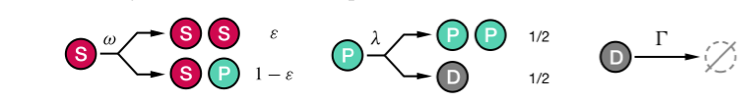

In [2]:
Image("cell_division.png")


In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 = omega * epsilon
    Reaction 2: S > S + P,    rate of reaction k2 = omega * (1 - epsilon)
    Reaction 3: P > P + P,    rate of reaction k3 = lambda * 0.5
    Reaction 4: P > D,        rate of reaction k4 = lambda * 0.5
    Reaction 5: D > none,     rate of reaction k5 = gamma
    
For each simulation, 
    
    1. the propensity function for each reaction is calculated based of the number reactant cells (S, P, D) in the population and the rate of reaction;
    2. a first random number is generated to decide time for next reaction;
    3. a second random number is generated to decide which reaction occurs next;
    4. as the reaction occurs, the number of cells (reactant and product) in the population is updated.

## Simulating the clonal size at counting time point

In [3]:
def clonalSizeSimulation(stemDivRate, epsilon, proDivRate, apoptosisRate,countingTimePoint,seed):
    S = 1
    P = 0
    D = 0
    reactionTime = 0
    random.seed(seed)
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate

    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime + t > countingTimePoint:
            N = S + P + D
            cont = False
        else:
            reactionTime += t
#             second random number generator to determine which reaction occurs
#             random.seed(seed+1)
            r2 = random.random()
            if r2 < A1/A0:
                S += 1
            elif r2 < (A1+A2+A3)/A0:
                P += 1
            elif r2 < (A1+A2+A3+A4)/A0:
                P -= 1
                D += 1
            else:
                D -= 1
            N = S + P + D
#             print('reaction time = ' + str(reactionTime))
#             print('clone size = ' + str(N))
    return(N)

testingSizes = clonalSizeSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=50,seed=5)
print(testingSizes)

11


## Multiple simulation

In Lan et al.'s study, the stem cell hierarchy model was simulated for 10^5 times. This large sample size will produce a distribution of clone sizes.

CPU times: user 5.27 s, sys: 17.1 ms, total: 5.28 s
Wall time: 5.3 s


(array([563., 198., 106.,  55.,  33.,  23.,  10.,   6.,   1.,   5.]),
 array([  1. ,  48.2,  95.4, 142.6, 189.8, 237. , 284.2, 331.4, 378.6,
        425.8, 473. ]),
 <a list of 10 Patch objects>)

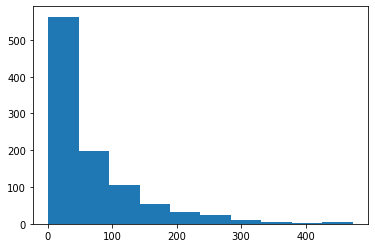

In [4]:
def multiSizeSimulation(n):
    # N: the number of parallele tasks   
    simulation = 1000
    clones = np.zeros(simulation)
    for i in range(simulation):
        clones[i] = clonalSizeSimulation(stemDivRate=0.15, epsilon=0.15, proDivRate=1.0, apoptosisRate=0.48,countingTimePoint=80, seed=n*simulation+i)
    return(clones)

%time testing = multiSizeSimulation(5)
plt.hist(testing)

In [5]:
if __name__ == '__main__':
    with Pool(8) as p:
        %time testingResult = p.map(multiSizeSimulation, range(10))

CPU times: user 18.1 ms, sys: 4.57 ms, total: 22.6 ms
Wall time: 23.5 s


(array([7.208e+03, 1.746e+03, 6.710e+02, 2.430e+02, 7.600e+01, 3.200e+01,
        1.400e+01, 4.000e+00, 2.000e+00, 4.000e+00]),
 array([  1. ,  78.4, 155.8, 233.2, 310.6, 388. , 465.4, 542.8, 620.2,
        697.6, 775. ]),
 <a list of 10 Patch objects>)

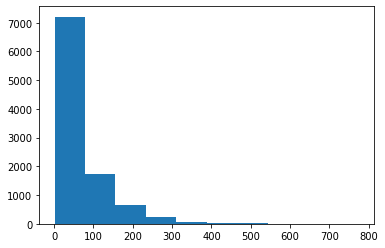

In [6]:
testingCloneSizes = np.concatenate(testingResult)
plt.hist(testingCloneSizes)

In [7]:
print(np.mean(testingCloneSizes))

62.7452


## Negative Binomial Distribution

In Lan et al.'s experiments, the sizes of the tumour clones showed a negative binomial distribution (NBD). Therefore, the fitness of the simulated data to NBD is also checked.

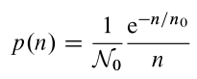

In [8]:
Image("NBD.png")

where  

    n = clone size,
    p(n) = the probability of having clone size of n,
    n0 = division rate of progenitor cell * t / 2,
    N0 = ln(n0)

In [9]:
def negativeBinomialDistribution(divisionRate, countingTimePoint, n):
    n0 = divisionRate * countingTimePoint / 2
    N0 = np.log(n0)
    P = 1 / N0 * np.exp(-n/n0) / n
    return(P)

testingCloneSizeRange = np.asarray(range(int(max(testingCloneSizes))))
testingNBD = negativeBinomialDistribution(divisionRate=1, countingTimePoint=80, n=testingCloneSizeRange)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


minimum clone size = 1
maximum clone size = 775


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


CPU times: user 2.45 s, sys: 23.2 ms, total: 2.48 s
Wall time: 2.48 s


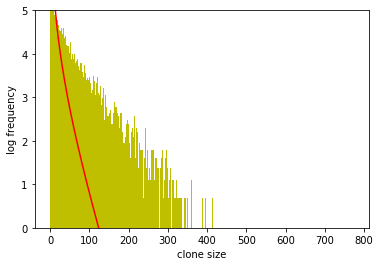

In [10]:
def logSizeDistribution(cloneSizes,NBD):
    minimum = int(min(cloneSizes))
    print('minimum clone size = ' + str(minimum))
    maximum = int(max(cloneSizes))
    print('maximum clone size = ' + str(maximum))
    x = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    plt.bar(x,np.log(freq),width=2,color='y') 
    plt.plot(x, np.log(len(cloneSizes)*NBD), 'r')
    plt.ylim((0, 5))
    plt.xlabel('clone size')
    plt.ylabel('log frequency')
    
%time logSizeDistribution(testingCloneSizes,testingNBD)

In Lan et al.'s paper, to further detect the NBD of clone sizes, first incomplete moment (FIM) was also applied. By definition, FIM gives the relative average clone size of all clones with sizes larger than n.

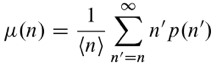

In [11]:
Image("FIM.png")

where

    <n> indicates the average clone size

If the clone size follows a negative binomial distribution, then FIM will follows an exponential distribution, which will be linear in a logarithm scale.

In [12]:
def firstIncompleteMoment(cloneSizes):
    maximum = int(max(cloneSizes))
    cloneSizeRange = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    prob = freq/sum(freq)
    averageCloneSize = np.mean(cloneSizes)
    step1 = np.array([i*p for (i,p) in enumerate(prob,1)])
    step2 = np.zeros(maximum)
    for i in range(maximum):
        step2[i]=step1[maximum-i-1]
    step3 = np.cumsum(step2)
    step4 = np.zeros(maximum)
    for i in range(maximum):
        step4[i]=step3[maximum-i-1]
    mu = step4/averageCloneSize
    return(mu)
    
%time testingMu = firstIncompleteMoment(testingCloneSizes)

CPU times: user 1.85 s, sys: 9.47 ms, total: 1.86 s
Wall time: 1.87 s


In [13]:
def logSizePlot(X,y):
    Y = np.log(y)
    plt.plot(X,Y,'b')
    plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),'r')
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')

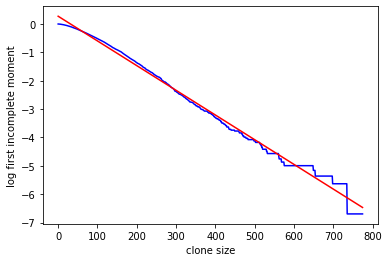

In [14]:
logSizePlot(testingCloneSizeRange,testingMu)

## Simulating the clonal size across passages

In Lan et al.'s experiment, about 5% of the harvesting cells are chosen for reinjection. These reinjected cells consist of stem cells and progenitor cell since differentiated cells were unlikely to survive during the process of serial transplantation. 

Before the primary passage, the tumour sample extracted was in a steady status. Acrroding to Lan et al., the cell composition is:

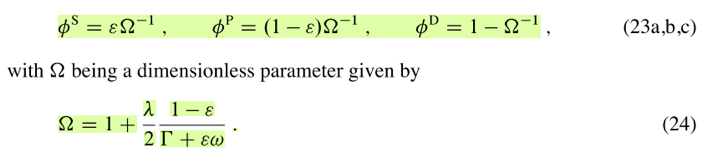

In [15]:
Image("SPD.png")

In [16]:
Lambda = 1
Epsilon = 0.15
Omega = 0.15
Gamma = 0.48

Ome = 1 + 0.5 * Lambda * (1 - Epsilon) / (Gamma + Epsilon * Omega)
print('Omega = ' + str(Ome))
# stem cell
S = Epsilon / Ome
print('Stem cell proportion = ' + str(S))
# progenitor cell
P = (1 - Epsilon) / Ome
print('Progenitor cell proportion = ' + str(P))
# differentiated cell
D = 1 - (S + P)
print('Differentiated cell proportion = ' + str(D))

Omega = 1.845771144278607
Stem cell proportion = 0.08126684636118599
Progenitor cell proportion = 0.4605121293800539
Differentiated cell proportion = 0.4582210242587601


In [17]:
def harvestClones(inject, parameters,countingTimePoint,seed):
    stemDivRate = parameters["stem_div_rate"]
    epsilon = parameters["epsilon"]
    proDivRate = parameters["pro_div_rate"]
    apoptosisRate = parameters["apoptosis_rate"]
    countingTimePoint = countingTimePoint
    seed = seed
    S = inject["stem"]
    P = inject["progenitor"]
    D = inject["differentiated"]
    reactionTime = 0
    random.seed(seed)
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate

    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime + t > countingTimePoint:
#             N = S + P + D
            cont = False
        else:
            reactionTime += t
#             second random number generator to determine which reaction occurs
#             random.seed(seed+1)
            r2 = random.random()
            if r2 < A1/A0:
                S += 1
            elif r2 < (A1+A2+A3)/A0:
                P += 1
            elif r2 < (A1+A2+A3+A4)/A0:
                P -= 1
                D += 1
            else:
                D -= 1
#             N = S + P + D
#             print('reaction time = ' + str(reactionTime))
#             print('clone size = ' + str(N))
    return{"stem":S, "progenitor":P, "differentiated":D}
    
primaryInject = {
    "stem":4,
    "progenitor":23,
    "differentiated":0}

parameters = {
    "stem_div_rate":0.15,
    "epsilon":0.15,
    "pro_div_rate":1.0,
    "apoptosis_rate":0.48}

testingClone = harvestClones(primaryInject, parameters,80,0)
print(testingClone)

{'stem': 39, 'progenitor': 103, 'differentiated': 123}


In this example, there are 4 stem cells and 23 progenitor cells injected, and there are 39 stem cells, 103 progenitor cells and 123 differentiated cells at harvest. Since only 5% of the harvested cells will be chosen for reinjection, 13 cells would be reinjected.

Using binomial distribution, we will now simulate the cell composition for reinjection.

In [18]:
testingReInject = np.random.binomial(n=13,p=39/(39+103))
print('number of stem cells in the reinjection = ' + str(testingReInject))

number of stem cells in the reinjection = 4


In [19]:
def transplantation(harvest):
    stemHarvest = harvest["stem"]
    proHarvest = harvest["progenitor"]
    diffHarvest = harvest["differentiated"]    
    totalHarvest = stemHarvest + proHarvest
#     + diffHarvest
    totalReinject = round(totalHarvest * 0.05)
    if stemHarvest + proHarvest > 0:
        stemProb = stemHarvest/(stemHarvest + proHarvest)
        stemReinject = np.random.binomial(n=totalReinject, p=stemProb)
        proReinject = totalReinject - stemReinject
    else:
        stemReinject = 0
        proReinject = 0
    return{"stem":stemReinject, "progenitor":proReinject, "differentiated":0}

testingReinject = transplantation(testingClone)
print(testingReinject)

{'stem': 2, 'progenitor': 5, 'differentiated': 0}


In [20]:
def serialPassage(primaryInject, parameters,seed):
    primaryHarvest = harvestClones(primaryInject, parameters,80,seed)
    primaryCloneSize = primaryHarvest["stem"] + primaryHarvest["progenitor"] + primaryHarvest["differentiated"]
    secondaryInject = transplantation(primaryHarvest)
    secondaryHarvest = harvestClones(secondaryInject, parameters,65,seed)
    secondaryCloneSize = secondaryHarvest["stem"] + secondaryHarvest["progenitor"] + secondaryHarvest["differentiated"]
    tertiaryInject = transplantation(secondaryHarvest)
    tertiaryHarvest = harvestClones(tertiaryInject, parameters,70,seed)
    tertiaryCloneSize = tertiaryHarvest["stem"] + tertiaryHarvest["progenitor"] + tertiaryHarvest["differentiated"]
    return{"primary":primaryCloneSize, "secondary":secondaryCloneSize, "tertiary":tertiaryCloneSize}

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 39.8 s, sys: 184 ms, total: 40 s
Wall time: 40.2 s


(array([852.,  58.,  36.,  23.,  10.,   9.,   7.,   1.,   2.,   2.]),
 array([  0. ,  55.3, 110.6, 165.9, 221.2, 276.5, 331.8, 387.1, 442.4,
        497.7, 553. ]),
 <a list of 10 Patch objects>)

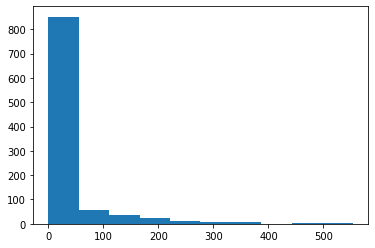

In [21]:
def multiPassage(n):
    # N: the number of parallele tasks   
    simulation = 1000
    clones = np.zeros(simulation)
    for i in range(simulation):
        clones[i] = serialPassage(primaryInject=primaryInject, parameters=parameters,seed=n*simulation+i)["tertiary"]
    return(clones)

%time testing = multiPassage(0)
plt.hist(testing)

In [22]:
if __name__ == '__main__':
    with Pool(8) as p:
        %time result = p.map(multiPassage, range(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in

CPU times: user 141 ms, sys: 36.8 ms, total: 178 ms
Wall time: 3min 10s


In [23]:
cloneSizes = np.concatenate(result)
print(np.mean(cloneSizes))

29.5308


In [24]:
cloneSizeRange = np.asarray(range(int(max(cloneSizes))))
%time mu = firstIncompleteMoment(cloneSizes)

CPU times: user 2.16 s, sys: 9.91 ms, total: 2.17 s
Wall time: 2.17 s


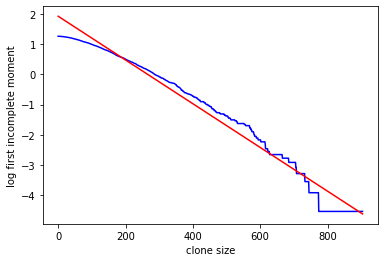

In [25]:
logSizePlot(cloneSizeRange,mu)

## Simulating the clonal grwoth till counting time point

final reaction time = 64.29206176337983
final clone size = 1


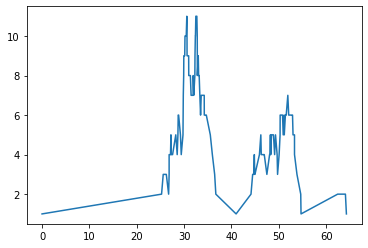

In [26]:
def clonalGrowthSimulation(stemDivRate, epsilon, proDivRate, apoptosisRate,countingTimePoint):
    S = np.array([1])
    P = np.array([0])
    D = np.array([0])
    N = np.array([1])
    reactionTime = np.array([0])
    
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate
    
    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S[-1]*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S[-1]*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P[-1]*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P[-1]*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D[-1]*k5
        A0 = A1 + A2 + A3 + A4 + A5
#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime[-1] + t > countingTimePoint:
            cont = False
        else:
            reactionTime = np.append(reactionTime,reactionTime[-1] + t)
#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S = np.append(S, S[-1]+1)
            elif r2 < (A1+A2+A3)/A0:
                P = np.append(P, P[-1]+1)
            elif r2 < (A1+A2+A3+A4)/A0:
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1]+1)
            else:
                D = np.append(D, D[-1]-1)
            N = np.append(N, S[-1]+P[-1]+D[-1])
    print('final reaction time = ' + str(reactionTime[-1]))
    print('final clone size = ' + str(N[-1]))
#     clonalGrowth = np.concatenate((reactionTime, N), axis=0)
    return{"reaction_time": reactionTime, "clone_size": N}

testingGrowth = clonalGrowthSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=80)
plt.plot(testingGrowth["reaction_time"],testingGrowth["clone_size"])

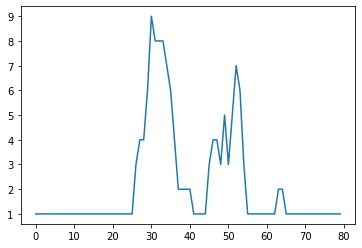

In [27]:
def cellCount(reactionTime, cell, countingTimePoint):
    time = range(countingTimePoint)
    count = np.zeros(len(time))
    for t in time:
        cellIndex = np.array(np.where(reactionTime <= t)[0])
        if cellIndex.size:
            cellTimeIndex = np.array(cellIndex[-1])
            count[t] = cell[cellTimeIndex]
        else:
            count[t] = cell[0]
    return(count)

testingCount = cellCount(testingGrowth["reaction_time"],testingGrowth["clone_size"],80)
plt.plot(range(len(testingCount)),testingCount)

In [28]:
def passageClonalGrowth(inject, parameters, countingTimePoint,seed):
    stemDivRate = parameters["stem_div_rate"]
    epsilon = parameters["epsilon"]
    proDivRate = parameters["pro_div_rate"]
    apoptosisRate = parameters["apoptosis_rate"]
    countingTimePoint = countingTimePoint
    seed = seed
    S = inject["stem"]
    P = inject["progenitor"]
    D = inject["differentiated"]
    reactionTime = np.array([0])
    
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate
    
    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S[-1]*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S[-1]*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P[-1]*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P[-1]*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D[-1]*k5
        A0 = A1 + A2 + A3 + A4 + A5
#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime[-1] + t > countingTimePoint:
            cont = False
        else:
            reactionTime = np.append(reactionTime,reactionTime[-1] + t)
#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S = np.append(S, S[-1]+1)
                P = np.append(P, P[-1])
                D = np.append(D, D[-1])
            elif r2 < (A1+A2+A3)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]+1)
                D = np.append(D, D[-1])
            elif r2 < (A1+A2+A3+A4)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1]+1)
            else:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1])
                D = np.append(D, D[-1]-1)
    stem = cellCount(reactionTime, S, countingTimePoint)
    pro = cellCount(reactionTime, P, countingTimePoint)
    diff = cellCount(reactionTime, D, countingTimePoint)
#     print('final reaction time = ' + str(reactionTime[-1]))
#     print('final clone size = ' + str(N[-1]))
    return{"stem":stem,"progenitor":pro,"differentiated":diff}


In [29]:
S = np.array([4])
P = np.array([23])
D = np.array([23])

primaryInject = {
    "stem":S,
    "progenitor":P,
    "differentiated":D}

parameters = {
    "stem_div_rate":0.15,
    "epsilon":0.15,
    "pro_div_rate":1.0,
    "apoptosis_rate":0.48}

testingPassageGrowth = passageClonalGrowth(primaryInject, parameters, 80, 0)

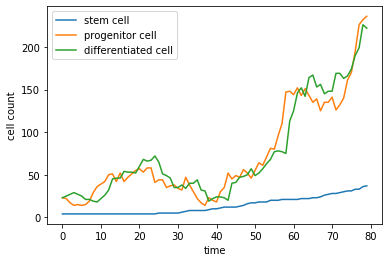

In [30]:
def cellExpansion(harvest):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    x = range(len(S))
    plt.plot(x,S,label='stem cell')
    plt.plot(x,P,label='progenitor cell')
    plt.plot(x,D,label='differentiated cell')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('cell count')
    
cellExpansion(testingPassageGrowth)

In [31]:
def transplantation(harvest):
    stemHarvest = harvest["stem"][-1]
    proHarvest = harvest["progenitor"][-1]
    diffHarvest = harvest["differentiated"][-1] 
    totalHarvest = stemHarvest + proHarvest
#     + diffHarvest
    totalReinject = round(totalHarvest * 0.05)
#    only stem cells and progenitor cells may survive during the process of serial transplantation. 
    if stemHarvest + proHarvest > 0:
        stemProb = stemHarvest/(stemHarvest + proHarvest)
        stemReinject = np.random.binomial(n=totalReinject, p=stemProb)
        proReinject = totalReinject - stemReinject
    else:
        stemReinject = 0
        proReinject = 0
    return{"stem":np.array([stemReinject]), "progenitor":np.array([proReinject]), "differentiated":np.array([0])}

In [32]:
def passageExpansion(primaryInject, parameters,seed):
    primaryHarvest = passageClonalGrowth(primaryInject, parameters,80,seed)
    secondaryInject = transplantation(primaryHarvest)
    secondaryHarvest = passageClonalGrowth(secondaryInject, parameters,65,seed)
    tertiaryInject = transplantation(secondaryHarvest)
    tertiaryHarvest = passageClonalGrowth(tertiaryInject, parameters,70,seed)
    S = np.concatenate((primaryHarvest["stem"],secondaryHarvest["stem"],tertiaryHarvest["stem"]))
    P = np.concatenate((primaryHarvest["progenitor"],secondaryHarvest["progenitor"],tertiaryHarvest["progenitor"]))
    D = np.concatenate((primaryHarvest["differentiated"],secondaryHarvest["differentiated"],tertiaryHarvest["differentiated"]))
    return{"stem":S, "progenitor":P, "differentiated":D}

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 720 ms, sys: 9.23 ms, total: 730 ms
Wall time: 728 ms


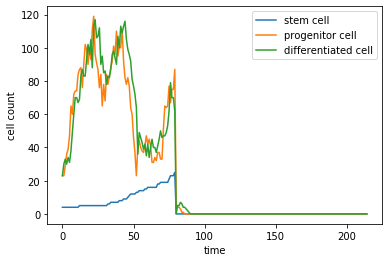

In [33]:
%time fullPassage = passageExpansion(primaryInject, parameters,0)
cellExpansion(fullPassage)

In [34]:
len(fullPassage["stem"])

215

In [35]:
80+65+70

215

In [36]:
def multiGrowthSimulation(n):
    # N: the number of parallele tasks   
    simulation = 1000
    stem = np.zeros((1000,215))
    pro = np.zeros((1000,215))
    diff = np.zeros((1000,215))
    for i in range(simulation):
        clone = passageExpansion(primaryInject=primaryInject, parameters=parameters, seed=n*simulation+i)
        stem[i][:] = clone["stem"]
        pro[i][:] = clone["progenitor"]
        diff[i][:] = clone["differentiated"]
    S = np.transpose(stem)
    P = np.transpose(pro)
    D = np.transpose(diff)
    meanS = np.array([np.mean(s) for s in S])
    meanP = np.array([np.mean(p) for p in P])
    meanD = np.array([np.mean(d) for d in D])
    return{"stem":meanS, "progenitor":meanP, "differentiated":meanD}

%time averageGrowth = multiGrowthSimulation(2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 13min 26s, sys: 3.88 s, total: 13min 30s
Wall time: 13min 33s


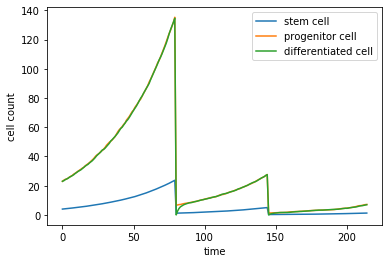

In [37]:
cellExpansion(averageGrowth)